In [1]:
#!/usr/bin/env python2
#Inspire du fichier train_fcn8.py

import os
import argparse
import time
from getpass import getuser
from distutils.dir_util import copy_tree

import numpy as np
import random
import theano
import theano.tensor as T
from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import categorical_crossentropy

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from fcn_1D_general import buildFCN_1D
from metrics import jaccard, accuracy, crossentropy
from cortical_layers import CorticalLayersDataset
from simple_model_1path import build_simple_model

%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN not available)


In [2]:
input_var = T.tensor3('input')

In [3]:
exp_name = 'simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25'


#Model hyperparameters
n_filters = 64
filter_size = [25]  
depth  = 8
data_augmentation={} #{'horizontal_flip': True, 'fill_mode':'constant'}
block = 'bn_relu_conv'

#Training loop hyperparameters
weight_decay=0.001
num_epochs=500
max_patience=25
resume=False
learning_rate_value = 0.0005
#learning rate is defined below as a theano variable.
#Hyperparameters for the dataset loader
batch_size=[1000,1000,1]
smooth_or_raw = 'both'
shuffle_at_each_epoch = True 
minibatches_subset = 5
n_layers=6

In [4]:
net = build_simple_model(input_var, filter_size = filter_size)

In [5]:
SAVEPATH = '/data1/data/kwagstyl/bigbrain/cortical_layers/'
LOADPATH = '/data1/data/kwagstyl/bigbrain/cortical_layers/'
WEIGHTS_PATH = LOADPATH

In [6]:
build_model_name = False

if build_model_name :
    exp_name = 'simple_model'
    exp_name += '_lrate=' + str(learning_rate_value)
    exp_name += '_fil=' + str(n_filters)
    exp_name += '_fsizes=' + str(filter_size)
    #uncomment this line if new version of train_function
    exp_name += '_depth=' + str(depth)
    exp_name += '_' + smooth_or_raw
    exp_name += '_decay=' + str(weight_decay)
    exp_name += '_pat=' + str(max_patience)
    exp_name += ('_noshuffle'+str(minibatches_subset)+'batch') if not shuffle_at_each_epoch else ''

    print exp_name
    
    

In [7]:
dataset = '6cortical_layers_all'
weight_path = os.path.join(WEIGHTS_PATH, dataset, exp_name, 'new_fcn1D_model_best.npz')

In [8]:
#
# Build dataset iterator
#
if smooth_or_raw =='both':
    nb_in_channels = 2
    use_threads = False
else:
    nb_in_channels = 1
    use_threads = True

train_iter = CorticalLayersDataset(
    which_set='train',
    smooth_or_raw = smooth_or_raw,
    batch_size=batch_size[0],
    data_augm_kwargs=data_augmentation,
    shuffle_at_each_epoch = shuffle_at_each_epoch,
    return_one_hot=False,
    return_01c=False,
    return_list=False,
    use_threads=use_threads,
    preload=True,
    n_layers=n_layers)

val_iter = CorticalLayersDataset(
    which_set='valid',
    smooth_or_raw = smooth_or_raw,
    batch_size=batch_size[1],
    shuffle_at_each_epoch = shuffle_at_each_epoch,
    return_one_hot=False,
    return_01c=False,
    return_list=False,
    use_threads=use_threads,
    preload=True,
    n_layers=n_layers)

test_iter = None


n_batches_train = train_iter.nbatches
n_batches_val = val_iter.nbatches
n_batches_test = test_iter.nbatches if test_iter is not None else 0
n_classes = train_iter.non_void_nclasses
void_labels = train_iter.void_labels



In [9]:
#
# Define symbolic variables
#
input_var = T.tensor3('input_var') #n_example*nb_in_channels*ray_size
target_var = T.ivector('target_var') #n_example*ray_size

learn_step=  theano.shared(np.array(learning_rate_value, dtype=theano.config.floatX))

In [10]:
#
# Build model and assign trained weights
#
simple_net_output, net = build_simple_model(input_var,
                    filter_size = filter_size,
                    n_filters = n_filters,
                    depth = depth,
                    block= block,
                    nb_in_channels = nb_in_channels,
                    n_classes = n_classes)
#must be set to 1 for the new models
                    #in the last version, last_filter_size was uncorrectly set to 3
                    #so, in order to recover/resassign weights correctly, must be a
                    #"new" parameter

print 'Done building model'

with np.load(weight_path) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    
nlayers=len(lasagne.layers.get_all_params(simple_net_output))
lasagne.layers.set_all_param_values(simple_net_output, param_values[:nlayers])

print 'Done assigning weights'

Done building model
Done assigning weights


In [11]:
print "Defining and compiling test functions"
test_prediction = lasagne.layers.get_output(simple_net_output[0],
                                            deterministic=True)
test_loss = categorical_crossentropy(test_prediction, target_var)
test_loss = test_loss.mean()
test_acc, test_acc_per_sample =accuracy(test_prediction, target_var, void_labels)
test_jacc = jaccard(test_prediction, target_var, n_classes)

test_fn = theano.function([input_var, target_var], [test_loss, test_acc,
                                                   test_jacc, test_acc_per_sample])
print "Done"

Defining and compiling test functions
Done


In [12]:
#Function computing the prediction with current parameters (for visualization)
pred = theano.function([input_var], lasagne.layers.get_output(net['probs_reshape'],
                                            deterministic=True))

In [13]:
#To visualize the ray 
def make_2Darray(arr, height = 25):
    arr = np.reshape(arr, (1,arr.shape[0]))
    x = np.repeat(arr, height, 0)
    return x

In [14]:
def profile2indices(profile):
    if 8 in profile or len(set(profile))<5:
        #If nonsense profile, return all indices as zeros.
        Indices=[0,0,0,0,0,0,0]
        return Indices
    else:
        try :
            if profile.index(0) < 100:
                profile[0:profile.index(0)]=[0]*profile.index(0)
                if 8 in profile or len(set(profile))<5:
                    Indices=[0,0,0,0,0,0,0]
                    return Indices
        except ValueError:
            pass
        try :
        #Get index of first layer 1
            Indices=[profile.index(1)]
        except ValueError:
        #If no layer 1s, get first nonzero,
        #  sometimes layer 1 is ripped off but we still want locations of other layers
            Indices=[next((i for i, x in enumerate(profile) if x), None)]
        #then set all before that to 1, to get rid of some nonsense
        profile[0:Indices[0]]=[1]*Indices[0]
        try :
            Indices.append(profile.index(2))
        except ValueError:
            try :
                Indices.append(len(profile)-profile[::-1].index(1)-1)
            except ValueError:
                return [0,0,0,0,0,0,0]
        #If no layer 2
        #then set all before that to 2,
        profile[0:Indices[1]]=[2]*Indices[1]
        try :
            Indices.append(profile.index(3))
        except ValueError:
        #If no layer 3
            try :
                Indices.append(profile.index(4))
            except ValueError:
                #if no layer 3 or 4, nonsense
                try :
                    Indices.append(profile.index(5))
                except ValueError:
#                    print("error b")
                    return [0,0,0,0,0,0,0]
        profile[0:Indices[2]]=[3]*Indices[2]
        try :
            Indices.append(profile.index(4))
        except ValueError:
            Indices.append(len(profile)-profile[::-1].index(3)-1)
        profile[0:Indices[3]]=[4]*Indices[3]
        try :
            Indices.append(profile.index(5))
        except ValueError:
            Indices.append(len(profile)-profile[::-1].index(4)-1)
        profile[0:Indices[4]]=[5]*Indices[4]
        try :
            Indices.append(profile.index(6))
        except ValueError:
            Indices.append(len(profile)-profile[::-1].index(5)-1)
        #get last occurance of index 4.
        try:
            Indices.append(len(profile)-profile[::-1].index(6)-1)
        except ValueError:
            Indices.append(len(profile)-profile[::-1].index(5)-1)
    return Indices;


In [21]:
hemi='left'
Raw = '/data1/data/kwagstyl/bigbrain/TestData/raw_'+hemi+'.txt'
Geo = '/data1/data/kwagstyl/bigbrain/TestData/geo_'+hemi+'.txt'


In [22]:
geo=np.loadtxt(Geo)
raw=np.loadtxt(Raw)


In [23]:
data=np.hstack([geo,raw])

In [24]:
Data=np.reshape(data,[655362,2,200],order='A').astype('float32')

In [25]:
Dividers=np.round(np.linspace(0,655362,30)).astype(int)
Indices=np.zeros((655362,7))

k=-1
for D in range(len(Dividers)-1):
    predicted_labels=np.argmax(pred(Data[Dividers[D]:Dividers[D+1]]), axis=2)
    for p in predicted_labels:
        k+=1
        Is=profile2indices(p.tolist())
        Indices[k,:]=Is
        if k % 10000 ==0:
            print str(100* k / 655362.0) + '% done'

0.0% done
1.52587424965% done
3.0517484993% done
4.57762274895% done
6.10349699861% done
7.62937124826% done
9.15524549791% done
10.6811197476% done
12.2069939972% done
13.7328682469% done
15.2587424965% done
16.7846167462% done
18.3104909958% done
19.8363652455% done
21.3622394951% done
22.8881137448% done
24.4139879944% done
25.9398622441% done
27.4657364937% done
28.9916107434% done
30.517484993% done
32.0433592427% done
33.5692334923% done
35.095107742% done
36.6209819916% done
38.1468562413% done
39.6727304909% done
41.1986047406% done
42.7244789902% done
44.2503532399% done
45.7762274895% done
47.3021017392% done
48.8279759888% done
50.3538502385% done
51.8797244881% done
53.4055987378% done
54.9314729874% done
56.4573472371% done
57.9832214868% done
59.5090957364% done
61.0349699861% done
62.5608442357% done
64.0867184854% done
65.612592735% done
67.1384669847% done
68.6643412343% done
70.190215484% done
71.7160897336% done
73.2419639833% done
74.7678382329% done
76.2937124826% 

In [26]:
np.savetxt(''+hemi+'_indices.txt',Indices,fmt='%i')

In [ ]:

#import time
#run model
k=-1
Indices=np.zeros((655362,7))
with open(Raw,'r') as R, open(Geo,'r') as G:
    while True:
        try:
            k+=1
            rawline=R.readline().rstrip().split(' ')
            geoline=G.readline().rstrip().split(' ')
            raw=map( float, rawline)
            geo=map(float, geoline )
            data=(geo, raw)
            Data=np.reshape(data,[1,2,200]).astype('float32')
            predicted_labels = np.argmax(pred(Data), axis=2)
            Is=profile2indices(predicted_labels.tolist()[0])
            Indices[k,:]=Is
            if k % 10000 ==0:
                print str(100* k / 655362.0) + '% done'
            elif not isinstance(Is[4],int):
                print k
                print "not index error"
                break
        except ValueError:
            print "finished if " + str(k)+ "=655362"
            print "otherwise error"
            break
#predicted_labels = np.argmax(pred(Data), axis=2)




In [260]:
predicted_labels

array([[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6,
        6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [17]:
np.savetxt(''+hemi+'_indices.txt',Indices,fmt='%i')

In [106]:
#trouble shooting

R=open(Raw,'r')
G=open(Geo,'r')


In [234]:
k=-1
while k!=1309286:
    rawline=R.readline().rstrip().split(' ')
    geoline=G.readline().rstrip().split(' ')
    k+=1
    raw=map( float, rawline)
    geo=map(float, geoline )
    data=(geo, raw)
    Data=np.reshape(data,[1,2,200]).astype('float32')
    predicted_labels = np.argmax(pred(Data), axis=2)
    I=profile2indices(predicted_labels.tolist()[0])
    if I==[0,0,0,0,0,0,0]:
        break

In [262]:
I=profile2indices(predicted_labels.tolist()[0])

In [263]:
I

[0, 0, 0, 0, 0, 0, 0]

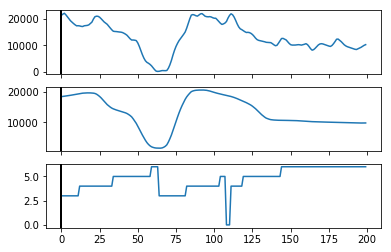

In [256]:
#plot profiles
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(raw)
axarr[1].plot(geo)
axarr[2].plot(predicted_labels[0])
for i in I:
    axarr[0].axvline(x=i,color=[i/200,i/200,i/200])
    axarr[1].axvline(x=i,color=[i/200,i/200,i/200])
    axarr[2].axvline(x=i,color=[i/200,i/200,i/200])
    

In [190]:
profile2indices(predicted_labels.tolist()[0])
    

[90, 111, 119, 118, 119, 139, 193]

In [182]:
predicted_labels

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])